In [216]:
%load_ext autoreload
%autoreload 2

import pandas as pd
from astropy.table import QTable
from astropy import units as u
from astropy import constants as const
import numpy as np
from matplotlib import pyplot as plt

from cluster import Cluster

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [217]:
mcxccls=pd.read_csv('data/mcxc|.txt', header=3, sep='|', skiprows=[4],on_bad_lines='warn', skipfooter=1)
mcxccls

/var/folders/99/vfh56jrs1nqcj8zqtcs5fkv40000gn/T/ipykernel_31336/1250100080.py:1: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support skipfooter; you can avoid this warning by specifying engine='python'.
  mcxccls=pd.read_csv('data/mcxc|.txt', header=3, sep='|', skiprows=[4],on_bad_lines='warn', skipfooter=1)


,MCXC,OName,AName,Ah Am RAs Ed Em Es,RAdeg DEdeg,GLON GLAT,z,Cat,Sub-Cat,Scale,...,R500,Notes,Cat1,Cat2,Cat3,Cat4,500r1,500r2,500r3,500r4
0,J0000.1+0816,RXC J0000.1+0816,UGC 12890 ...,0 0 7.1 + 8 16 28,0.030 8.274,101.783 -52.477,0.0396,NORAS/REFLEX,NORAS,0.784,...,0.6296,,BCS,,,,1.084,,,NaN
1,J0000.4-0237,RXC J0000.4-0237,...,0 0 24.7 - 2 37 30,0.103 -2.625,94.268 -62.622,0.0379,SGP,SGP,0.752,...,0.4817,,,,,,,,,NaN
2,J0001.6-1540,RXC J0001.6-1540,...,0 1 39.0 -15 40 52,0.412 -15.681,75.129 -73.733,0.1246,SGP,SGP,2.234,...,0.8021,,,,,,,,,NaN
3,J0001.9+1204,RXC J0001.9+1204,A2692 ...,0 1 57.0 +12 4 23,0.488 12.073,104.308 -49.001,0.2033,NORAS/REFLEX,NORAS,3.342,...,0.9178,,,,,,,,,NaN
4,J0003.1-0605,RXCJ0003.1-0605,A2697 ...,0 3 11.8 - 6 5 10,0.799 -6.086,92.169 -66.033,0.2320,NORAS/REFLEX,REFLEX,3.698,...,1.1326,,SGP,,,,0.952,,,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1738,J2357.0-3445,RXCJ2357.0-3445,A4059 ...,23 57 2.3 -34 45 38,359.260 -34.761,356.359 -76.082,0.0475,NORAS/REFLEX,REFLEX,0.931,...,0.9640,L,EMSS_1994,SGP,,,0.132,0.952,,NaN
1739,J2359.3-6042,RXCJ2359.3-6042,A4067 ...,23 59 19.2 -60 42 0,359.830 -60.700,314.102 -55.284,0.0989,NORAS/REFLEX,REFLEX,1.826,...,0.8572,,,,,,,,,NaN
1740,J2359.4-3418,MS2356.9-3434,...,23 59 27.3 -34 18 22,359.864 -34.306,357.005 -76.739,0.1150,EMSS,EMSS_1994,2.085,...,0.6198,,,,,,,,,NaN
1741,J2359.5-3211,RX J2359.5-3211,BSe RXJ2359.5-3211 ...,23 59 36.0 -32 11 6,359.900 -32.185,5.630 -77.667,0.4780,SHARC,SHARC_SOUTH,5.957,...,0.6776,,,,,,,,,NaN


In [218]:
mcxccls.columns=mcxccls.columns.str.strip()
mcxccls.columns.tolist()

['MCXC',
 'OName',
 'AName',
 'Ah Am  RAs  Ed Em Es',
 'RAdeg   DEdeg',
 'GLON    GLAT',
 'z',
 'Cat',
 'Sub-Cat',
 'Scale',
 'L500',
 'M500',
 'R500',
 'Notes',
 'Cat1',
 'Cat2',
 'Cat3',
 'Cat4',
 '500r1',
 '500r2',
 '500r3',
 '500r4']

In [219]:
mcxccls['M500']

0       0.7373
1       0.3297
2       1.6557
3       2.6927
4       5.2188
         ...  
1738    2.6658
1739    1.9699
1740    0.7568
1741    1.4784
1742    2.1579
Name: M500, Length: 1743, dtype: float64

In [200]:
cls_data={'M500':mcxccls['M500'],
          'L500':mcxccls['L500'],
          'R500':mcxccls['R500']
         }
units={
    'M500': 1e14*u.Msun,
    'L500': 1e37*u.W,
    'R500':u.Mpc
}

In [201]:
cls_table=QTable(cls_data, units=units)

In [202]:
cls_table

M500,L500,R500
1e+14 solMass,1e+37 W,Mpc
float64,float64,float64
0.7373,0.19628,0.6296
0.3297,0.052338,0.4817
1.6557,0.814902,0.8021
2.6927,1.990205,0.9178
5.2188,6.107094,1.1326
1.2016,0.441862,0.7388
...,...,...
2.1719,1.307553,0.871


In [203]:
i=1
test_cluster=Cluster(cls_table['R500'][i], cls_table['M500'][i], L500=cls_table['L500'][i], m500=cls_table['M500'][i])

In [204]:
test_cluster.mass

<Quantity 3.677527e+70 GeV>

In [205]:
test_cluster.baryon_temp

<Quantity 9.23082525e-07 GeV>

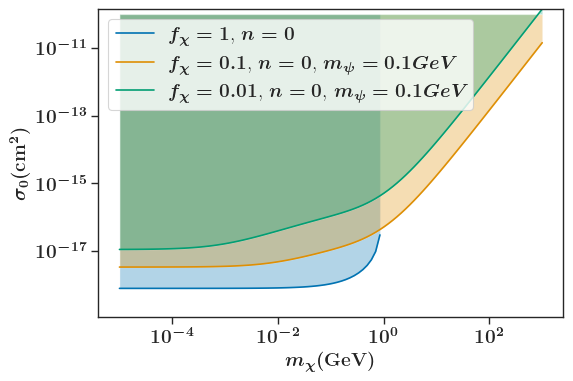

In [206]:
test_cluster.plot_sigma0_vs_m_chi(f_chi=[1, 0.1, 0.01], n=[0], region=True, fontsize='x-large')

In [207]:
cls_table['M500'].min(), cls_table['M500'].max()

(<Quantity 0.0096 1e+14 solMass>, <Quantity 22.1 1e+14 solMass>)

In [208]:
cls_table['L500'].min(), cls_table['L500'].max()

(<Quantity 0.000153 1e+37 W>, <Quantity 37.304424 1e+37 W>)

In [209]:
from cluster import temp_from_luminosity
temp_from_luminosity(cls_table['L500'].min()), temp_from_luminosity(cls_table['L500'].max())

(<Quantity 1.21712666e-07 GeV>, <Quantity 9.03328708e-06 GeV>)

In [210]:
temp_from_luminosity(cls_table['L500'].min()).to(u.K, equivalencies=u.temperature_energy()),temp_from_luminosity(cls_table['L500'].max()).to(u.K, equivalencies=u.temperature_energy())


(<Quantity 1412416.83704192 K>, <Quantity 1.04826944e+08 K>)

In [211]:
cls_table['R500'].min(), cls_table['R500'].max()

(<Quantity 0.1497 Mpc>, <Quantity 1.69 Mpc>)

In [212]:
# sanity check
m_chi=0.1*u.GeV
n_dm = test_cluster.rho_dm/m_chi
sigma_0 = 1e-24*u.cm**2
v = (const.G*test_cluster.mass.to(u.kg, equivalencies=u.mass_energy())/(test_cluster.radius).to(u.m))**(1/2)
n_dm, sigma_0, v

(<Quantity 0.0240618 1 / cm3>,
 <Quantity 1.e-24 cm2>,
 <Quantity 542564.90021259 m / s>)

In [215]:
test_cluster.rho_dm

<Quantity 0.00240618 GeV / cm3>

In [49]:
interaction_rate = (n_dm*sigma_0*v).to(1/u.Gyr)
interaction_rate, 1/interaction_rate

(<Quantity 0.04119873 1 / Gyr>, <Quantity 24.27259128 Gyr>)

In [63]:
m_chi=1000*u.GeV
n_dm = test_cluster.rho_dm/m_chi
sigma_0 = 1e-19*u.cm**2
v = (const.G*test_cluster.mass.to(u.kg, equivalencies=u.mass_energy())/(test_cluster.radius).to(u.m))**(1/2)
n_dm, sigma_0, v

(<Quantity 2.40618046e-06 1 / cm3>,
 <Quantity 1.e-19 cm2>,
 <Quantity 542564.90021259 m / s>)

In [64]:
interaction_rate = (n_dm*sigma_0*v).to(1/u.Gyr)
interaction_rate, 1/interaction_rate
# but this is out of range because the 1-comp DM is only valid for m_chi<1GeV

(<Quantity 0.41198733 1 / Gyr>, <Quantity 2.42725913 Gyr>)

In [65]:
# alternatively, make some of the DM non-interacting
m_chi=0.1*u.GeV
fx = 0.1
rho_chi = test_cluster.rho_dm/m_chi * fx
n_chi = rho_chi/m_chi
sigma_0 = 1e-19*u.cm**2
v = (const.G*test_cluster.mass.to(u.kg, equivalencies=u.mass_energy())/(test_cluster.radius).to(u.m))**(1/2)
n_dm, sigma_0, v

(<Quantity 2.40618046e-06 1 / cm3>,
 <Quantity 1.e-19 cm2>,
 <Quantity 542564.90021259 m / s>)

In [66]:
interaction_rate = (n_dm*sigma_0*v).to(1/u.Gyr)
interaction_rate, 1/interaction_rate
# now we are in range

(<Quantity 0.41198733 1 / Gyr>, <Quantity 2.42725913 Gyr>)

In [113]:
def interaction_time(m_chi, f_chi, cluster):
    rho_chi = cluster.rho_dm * f_chi
    n_chi = rho_chi/m_chi # number density of IDM
    v = (const.G*cluster.mass.to(u.kg, equivalencies=u.mass_energy())/(cluster.radius).to(u.m))**(1/2)
    sigma_0 = s0(cluster, m_chi, f_chi=f_chi)
    interaction_rate = (n_chi*sigma_0*v).to(1/u.Gyr)
    return 1/interaction_rate
    

In [116]:
interaction_time(100*u.GeV, 0.01, test_cluster)

<Quantity 1.69852877e-06 Gyr>

In [186]:
from cluster import c
# function to return sigma_0 for a single m_chi
def s0(cluster, m_chi, f_chi=1, m_psi=0.1 * u.GeV, n=0):
    dm_temp = cluster.virial_temperature(m_chi, f_chi=f_chi, m_psi=m_psi)
    uth = np.sqrt(cluster.baryon_temp / cluster.m_b + dm_temp / m_chi)
    rho_chi = cluster.rho_dm * f_chi
    total_heating_rate = cluster.agn_heating_rate() - cluster.radiative_cooling_rate()
    numerator = total_heating_rate * (m_chi + cluster.m_b) ** 2
    denominator = (
        3
        * (cluster.baryon_temp - dm_temp)
        * rho_chi
        * cluster.rho_b
         * cluster.volume
         * c(n)
         * uth ** (n + 1)
         * const.c.to(u.cm / u.s)
     )
    sigma0 = (numerator / denominator).to(u.cm**2)
    return sigma0*1e-6

    


In [187]:
s0(test_cluster, 0.1*u.GeV, f_chi=0.1)

<Quantity 1.06872881e-23 cm2>

In [192]:
n=100
fxs = np.logspace(-4, 0, n)
mxs = np.logspace(-6, 3, n)

m, f = np.meshgrid(mxs, fxs)

int_time = np.zeros((n,n)) * u.Gyr
int_time_above_1Gyr = np.zeros((n,n))

for i in range(n):
    for j in range(n):
        int_time[i, j] = interaction_time(m[i, j]*u.GeV, f[i, j], test_cluster)
        int_time_above_1Gyr[i, j] = 1 if int_time[i,j].value >= 1 else 0


In [193]:
int_time

<Quantity [[ 2.07755425e-02,  2.16067824e-02,  2.24693320e-02, ...,
             1.87799099e-01,  1.80174141e-01,  1.72858203e-01],
           [ 2.06051964e-02,  2.14304275e-02,  2.22868038e-02, ...,
             1.87799057e-01,  1.80174101e-01,  1.72858165e-01],
           [ 2.04359134e-02,  2.12551535e-02,  2.21053732e-02, ...,
             1.87799015e-01,  1.80174061e-01,  1.72858126e-01],
           ...,
           [ 3.14148721e-04,  3.27469839e-04,  3.41355823e-04, ...,
            -4.05947124e-01, -3.89511651e-01, -3.73738547e-01],
           [ 3.12683380e-04,  3.25942363e-04,  3.39763576e-04, ...,
            -1.00898512e+00, -9.68182017e-01, -9.29019534e-01],
           [ 3.11238125e-04,  3.24435825e-04,  3.38193156e-04, ...,
            -2.90780873e+02, -2.90817057e+02, -2.90851774e+02]] Gyr>

In [194]:
int_time_above_1Gyr

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

Text(0, 0.5, '$f_{\\chi}$')

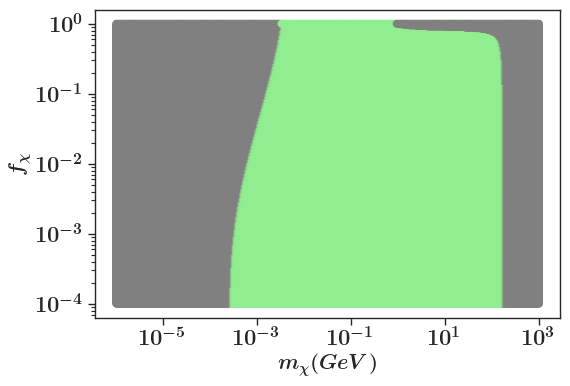

In [195]:
from matplotlib import colors
plt.scatter(m, f, c=int_time_above_1Gyr, cmap=colors.ListedColormap(['gray', 'lightgreen']))
ax=plt.gca()
ax.set_xscale('log')
ax.set_yscale('log')
plt.xlabel(r'$m_{\chi} (GeV)$', size=15)
plt.ylabel(r'$f_{\chi}$', size=15)



In [179]:
#from matplotlib.patches import Patch
#legend_elements = [Patch(facecolor='gray',label=r'$T_{\chi}>T_b$'), 
#                   Patch(facecolor='lightgreen',label=r'$T_{\chi}<T_b$')]
#ax.legend(handles=legend_elements, loc='lower left')
